In [1]:
from Bio import Entrez
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
def search(query):
    Entrez.email = 'your.email@example.com'
    handle = Entrez.esearch(db='pubmed',
                            sort='relevance',
                            retmax='20',
                            retmode='xml',
                            term=query)
    results = Entrez.read(handle)
    return results

def fetch_details(id_list):
    ids = ','.join(id_list)
    Entrez.email = 'tkhan@sidra.org'
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=ids)
    results = Entrez.read(handle)
    return results


In [12]:
search("HLA-DRB1*11 AND allergy")

{'Count': '16', 'RetMax': '16', 'RetStart': '0', 'IdList': ['26026288', '26598658', '22548207', '15144462', '25975240', '31871193', '26056507', '27184863', '18412308', '17237562', '23331206', '24092415', '20214848', '23325094', '10051703', '10200020'], 'TranslationSet': [{'From': 'allergy', 'To': '"hypersensitivity"[MeSH Terms] OR "hypersensitivity"[All Fields] OR "allergy"[All Fields] OR "allergy and immunology"[MeSH Terms] OR ("allergy"[All Fields] AND "immunology"[All Fields]) OR "allergy and immunology"[All Fields]'}], 'TranslationStack': [{'Term': 'HLA-DRB1*11[All Fields]', 'Field': 'All Fields', 'Count': '292', 'Explode': 'N'}, {'Term': '"hypersensitivity"[MeSH Terms]', 'Field': 'MeSH Terms', 'Count': '365762', 'Explode': 'Y'}, {'Term': '"hypersensitivity"[All Fields]', 'Field': 'All Fields', 'Count': '175884', 'Explode': 'N'}, 'OR', {'Term': '"allergy"[All Fields]', 'Field': 'All Fields', 'Count': '234191', 'Explode': 'N'}, 'OR', {'Term': '"allergy and immunology"[MeSH Terms]', 

In [54]:
paper['MedlineCitation']['Article']['Journal']

{'ISSN': StringElement('1945-8932', attributes={'IssnType': 'Electronic'}), 'JournalIssue': DictElement({'Volume': '29', 'Issue': '3', 'PubDate': {'MedlineDate': '2015 May-Jun'}}, attributes={'CitedMedium': 'Internet'}), 'Title': 'American journal of rhinology & allergy', 'ISOAbbreviation': 'Am J Rhinol Allergy'}

In [40]:
paper['MedlineCitation']['Article'].keys()

dict_keys(['ArticleDate', 'Language', 'ELocationID', 'Journal', 'ArticleTitle', 'Pagination', 'Abstract', 'AuthorList', 'PublicationTypeList'])

In [265]:
alleleList = pd.read_csv("../data_primary/AlleleFrequency_protRes_2methods.csv")

multiMono = pd.read_csv("../tables/multi-monoAssociationValues.csv").set_index("AlleleAllergen")
tx = multiMono[multiMono.columns[multiMono.columns.str.contains("iter")]].min(axis=1).to_frame()
tx['allele'] = [i.split("_")[1] for i in tx.index]
tx['allergn'] = [i.split("_")[0] for i in tx.index]
tx = tx.rename({0:'MinSuccIter'},axis=1)
tx.allele.nunique()

21

In [267]:
searchIdx = pd.DataFrame(index=alleleList[alleleList.selectedForStudy==1].ProtRes.values)
for k in alleleList[alleleList.selectedForStudy==1].ProtRes.values:
    query = "[{}] AND Allergy".format(k.replace("*","\*"))
    results = search(query)
    if int(results['Count'])>=1:
        searchIdx.loc[k,'count'] = int(results['Count'])
        searchIdx.loc[k,'pubmedID'] = ",".join(results['IdList'])
        
sigAlleleAllergy = searchIdx.loc[tx.allele.unique()]

pubMedList = []
pubMedListKeys = {}

for i in sigAlleleAllergy.dropna().index:
    pubMedList.extend(sigAlleleAllergy.loc[i,'pubmedID'].split(","))
    for x in sigAlleleAllergy.loc[i,'pubmedID'].split(","):
        if x in list(pubMedListKeys.keys()):
            pubMedListKeys[x].append(i)
        else:
            pubMedListKeys[x]= [i]
            
pubMedList = set(pubMedList)
print (len(pubMedList),len(list(pubMedListKeys.keys())))


98 98


In [268]:
articleDetail = {}

for k in pubMedListKeys.keys():
    
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=k)
    results = Entrez.read(handle)
    articleDetail[k] = {}
    if len(list(results.keys()))>1:
        rx = results['PubmedArticle'][0]['MedlineCitation']
        articleDetail[k]['Title'] = rx['Article']['ArticleTitle']
        articleDetail[k]['JournalName'] = rx['Article']['Journal']['Title']
        articleDetail[k]['JournalIssue'] = rx['Article']['Journal']['JournalIssue']
        try:
            articleDetail[k]['Abstract'] = rx['Article']['Abstract']['AbstractText'][0]
        except:
            pass
    else:
        rx = results['MedlineCitation']
        articleDetail[k]['Title'] = rx['Article']['ArticleTitle']
        articleDetail[k]['JournalName'] = rx['Article']['Journal']['Title']
        articleDetail[k]['JournalIssue'] = rx['Article']['Journal']['JournalIssue']
        try:
            articleDetail[k]['Abstract'] = rx['Article']['Abstract']['AbstractText'][0]
        except:
            pass

articleDetailDF_Allergy = pd.DataFrame(articleDetail).T

In [269]:
articleDetailDF_Allergy

,Title,JournalName,JournalIssue,Abstract
27166610,Protective Role of HLA-DRB1*13:02 against Micr...,PloS one,"{'Volume': '11', 'Issue': '5', 'PubDate': {'Ye...",Among antineutrophil cytoplasmic antibody (ANC...
30235330,Independent association of HLA-DPB1*02:01 with...,PloS one,"{'Volume': '13', 'Issue': '9', 'PubDate': {'Ye...",Rheumatoid arthritis (RA) is a chronic autoimm...
27116456,Human Leukocyte Antigen and Systemic Sclerosis...,PloS one,"{'Volume': '11', 'Issue': '4', 'PubDate': {'Ye...",Several studies on associations between human ...
30278218,"Sequence-based HLA-A, B, C, DP, DQ, and DR typ...",Human immunology,"{'Volume': '79', 'Issue': '12', 'PubDate': {'Y...","DNA sequence-based typing at the HLA-A, -B, -C..."
31815739,Epitope-specific airway-resident CD4+ T cell d...,The Journal of clinical investigation,"{'Volume': '130', 'Issue': '1', 'PubDate': {'Y...",BACKGROUNDRespiratory syncytial virus (RSV) is...
...,...,...,...,...
31985601,HLA-DRB1*15: 02 Is Associated With Iodinated C...,Investigative radiology,"{'Volume': '55', 'Issue': '5', 'PubDate': {'Ye...",The incidence of severe reaction induced by io...
16792590,HLA DRB1*15-DPB1*05 haplotype: a susceptible g...,Allergy,"{'Volume': '61', 'Issue': '7', 'PubDate': {'Ye...",There has been no study for evaluating the ass...
12197571,Possible association between cockroach allergy...,"Annals of allergy, asthma & immunology : offic...","{'Volume': '89', 'Issue': '2', 'PubDate': {'Ye...",Susceptibility to the development of allergic ...
31449552,Protective HLA alleles are associated with red...,PLoS pathogens,"{'Volume': '15', 'Issue': '8', 'PubDate': {'Ye...",Despite extensive research on the mechanisms o...


In [275]:
qw = "|".join(sigAllele.dropna().index).replace("*","\*")
qw

'DPB1\\*04:02|DPB1\\*09:01|DPB1\\*17:01|DQB1\\*03:03|DRB1\\*08:04|DRB1\\*13:03|DRB1\\*15:03|DRB1\\*16:01|DQB1\\*06:03|DRB1\\*01:02|DRB1\\*11:04|DRB1\\*13:01|DQB1\\*05:01|DQB1\\*06:04|DRB1\\*10:01|DRB1\\*13:02|DPB1\\*13:01|DQB1\\*05:03|DRB1\\*11:01|DRB1\\*15:02'

In [277]:
articleDetailDF_Allergy = pd.DataFrame(articleDetailDF_Allergy).T
articleDetailDF_Allergy = articleDetailDF_Allergy.dropna()
alleleArticle = []
for k in sigAllele.index:
    _pindex = articleDetailDF_Allergy[articleDetailDF_Allergy.Abstract.str.contains(k.replace("*","\*"))].index
    for p in _pindex:
        alleleArticle.append([p,k])
        
allelArticleMap_Allergy = pd.DataFrame(alleleArticle,columns=['pubmedID','allele']).groupby("pubmedID")['allele']\
                        .apply(list).to_frame().join(articleDetailDF_Allergy[articleDetailDF_Allergy.Abstract.str.contains(qx)])

In [280]:
allelArticleMap_Allergy['Year'] = [allelArticleMap_Allergy.loc[k,'JournalIssue']['PubDate']['Year'] for k in allelArticleMap_Allergy.index]
allelArticleMap_Allergy

,allele,Title,JournalName,JournalIssue,Abstract,Year
pubmedID,,,,,,
21545408,"[DRB1*13:02, DRB1*15:02]",A study of HLA class I and class II 4-digit al...,International journal of immunogenetics,"{'Volume': '38', 'Issue': '4', 'PubDate': {'Ye...",Stevens-Johnson syndrome (SJS) and toxic epide...,2011
23278646,"[DRB1*11:04, DRB1*11:01]",HLA-DRB1 and HLA-DQB1 genes on susceptibility ...,Microbiology and immunology,"{'Volume': '57', 'Issue': '3', 'PubDate': {'Ye...",Allergic bronchopulmonary aspergillosis (ABPA)...,2013
23443026,[DQB1*06:03],HLA-DQB1*02 and DQB1*06:03P are associated wit...,European journal of human genetics : EJHG,"{'Volume': '21', 'Issue': '10', 'PubDate': {'Y...",Peanut allergy (PA) is a common and serious fo...,2013
24291122,"[DRB1*13:01, DRB1*11:01]",Genetic susceptibility to multicase hypersensi...,Respiratory medicine,"{'Volume': '108', 'Issue': '1', 'PubDate': {'Y...",Hypersensitivity Pneumonitis (HP) is a lung in...,2014
24498086,[DPB1*13:01],Association of HLA-DPB1 with scleroderma and i...,PloS one,"{'Volume': '9', 'Issue': '1', 'PubDate': {'Yea...",Human leukocyte antigen DPB1 was reported to c...,2014
24498373,[DRB1*13:02],Human leukocyte antigens and systemic lupus er...,PloS one,"{'Volume': '9', 'Issue': '2', 'PubDate': {'Yea...",Many studies on associations between human leu...,2014
24911054,[DRB1*13:02],Protective effect of the HLA-DRB1*13:02 allele...,PloS one,"{'Volume': '9', 'Issue': '6', 'PubDate': {'Yea...",Rheumatoid arthritis (RA) is a chronic systemi...,2014
27166610,"[DQB1*03:03, DRB1*13:02]",Protective Role of HLA-DRB1*13:02 against Micr...,PloS one,"{'Volume': '11', 'Issue': '5', 'PubDate': {'Ye...",Among antineutrophil cytoplasmic antibody (ANC...,2016
27331404,[DRB1*13:02],Association of HLA-G 3' Untranslated Region Po...,PloS one,"{'Volume': '11', 'Issue': '6', 'PubDate': {'Ye...",HLA-G plays a role in fetal-maternal tolerance...,2016


## Irrespective OF alllergy

In [243]:
searchIdx = pd.DataFrame(index=alleleList[alleleList.selectedForStudy==1].ProtRes.values)
for k in alleleList[alleleList.selectedForStudy==1].ProtRes.values:
    query = "[{}] AND disease".format(k.replace("*","\*"))
    results = search(query)
    if int(results['Count'])>=1:
        searchIdx.loc[k,'count'] = int(results['Count'])
        searchIdx.loc[k,'pubmedID'] = ",".join(results['IdList'])

In [244]:
sigAlleleDisease = searchIdx.loc[tx.allele.unique()]

In [245]:
sigAlleleDisease

,count,pubmedID
DPB1*04:02,29.0,"32560041,26010309,23934009,33710355,27166610,3..."
DPB1*09:01,11.0,"27116456,33710355,31468541,35118816,24285682,2..."
DPB1*10:01,1.0,32004448
DPB1*17:01,6.0,"33421092,31310798,30906300,30952422,31810856,2..."
DQB1*03:03,319.0,"31993957,29667729,29222811,29513033,31254396,3..."
DRB1*08:04,94.0,"32240434,24055898,24899791,28894202,30175673,3..."
DRB1*13:03,157.0,"27759901,24498373,27166610,27116456,26605347,1..."
DRB1*15:03,240.0,"29362509,29691938,29683085,21833018,23793423,3..."
DRB1*16:01,60.0,"33221730,34186156,22862923,30095639,28083619,3..."
DQB1*06:03,150.0,"28894202,27013183,32439825,25940821,34655711,2..."


In [246]:
pubMedList = []
pubMedListKeys = {}

for i in sigAlleleDisease.dropna().index:
    pubMedList.extend(sigAlleleDisease.loc[i,'pubmedID'].split(","))
    for x in sigAlleleDisease.loc[i,'pubmedID'].split(","):
        if x in list(pubMedListKeys.keys()):
            pubMedListKeys[x].append(i)
        else:
            pubMedListKeys[x]= [i]
            
pubMedList = set(pubMedList)
print (len(pubMedList),len(list(pubMedListKeys.keys())))

231 231


In [252]:
articleDetail = {}

for k in pubMedListKeys.keys():
    
    handle = Entrez.efetch(db='pubmed',
                           retmode='xml',
                           id=k)
    results = Entrez.read(handle)
    articleDetail[k] = {}
    if len(list(results.keys()))>1:
        rx = results['PubmedArticle'][0]['MedlineCitation']
        articleDetail[k]['Title'] = rx['Article']['ArticleTitle']
        articleDetail[k]['JournalName'] = rx['Article']['Journal']['Title']
        articleDetail[k]['JournalIssue'] = rx['Article']['Journal']['JournalIssue']
        try:
            articleDetail[k]['Abstract'] = rx['Article']['Abstract']['AbstractText'][0]
        except:
            pass
    else:
        rx = results['MedlineCitation']
        articleDetail[k]['Title'] = rx['Article']['ArticleTitle']
        articleDetail[k]['JournalName'] = rx['Article']['Journal']['Title']
        articleDetail[k]['JournalIssue'] = rx['Article']['Journal']['JournalIssue']
        try:
            articleDetail[k]['Abstract'] = rx['Article']['Abstract']['AbstractText'][0]
        except:
            pass
        

In [250]:
k

'29076136'

In [257]:
articleDetailDF = pd.DataFrame(articleDetail).T
articleDetailDF = articleDetailDF.dropna()

In [258]:


alleleArticle = []
for k in sigAllele.index:
    _pindex = articleDetailDF[articleDetailDF.Abstract.str.contains(k.replace("*","\*"))].index
    for p in _pindex:
        alleleArticle.append([p,k])
        
allelArticleMap = pd.DataFrame(alleleArticle,columns=['pubmedID','allele']).groupby("pubmedID")['allele'].apply(list).to_frame().join(articleDetailDF[articleDetailDF.Abstract.str.contains(qx)])

In [262]:
allelArticleMap.loc['21214530','JournalIssue']['PubDate']['Year']

'2011'

In [263]:
allelArticleMap['Year'] = [allelArticleMap.loc[k,'JournalIssue']['PubDate']['Year'] for k in allelArticleMap.index]

In [284]:
allelArticleMap.to_csv("../tables/alleleDisease_pubmed.csv")

In [281]:
from matplotlib_venn import venn2

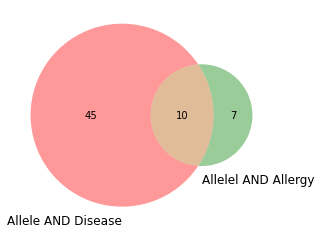

In [283]:
venn2([set(allelArticleMap.index),set(allelArticleMap_Allergy.index)],['Allele AND Disease', 'Allelel AND Allergy'])

In [286]:
allelArticleMap_Allergy.loc[set(allelArticleMap_Allergy.index) - set(allelArticleMap.index)]

/var/folders/v9/w_vjbp2j7qb395g17zpzcp180000gp/T/ipykernel_32210/765334126.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  allelArticleMap_Allergy.loc[set(allelArticleMap_Allergy.index) - set(allelArticleMap.index)]


,allele,Title,JournalName,JournalIssue,Abstract,Year
pubmedID,,,,,,
29348432,[DQB1*03:03],Genome-wide association study of self-reported...,Scientific reports,"{'Volume': '8', 'Issue': '1', 'PubDate': {'Yea...",Food allergy is an increasingly important heal...,2018
34880287,[DQB1*06:04],Targeted analysis of genomic regions enriched ...,Scientific reports,"{'Volume': '11', 'Issue': '1', 'PubDate': {'Ye...",Despite asthma has a considerable genetic comp...,2021
21545408,"[DRB1*13:02, DRB1*15:02]",A study of HLA class I and class II 4-digit al...,International journal of immunogenetics,"{'Volume': '38', 'Issue': '4', 'PubDate': {'Ye...",Stevens-Johnson syndrome (SJS) and toxic epide...,2011
33509297,[DRB1*13:01],Genetic risk factors for autoimmune hepatitis:...,Human genomics,"{'Volume': '15', 'Issue': '1', 'PubDate': {'Ye...",Autoimmune hepatitis (AIH) is a rare chronic p...,2021
27331404,[DRB1*13:02],Association of HLA-G 3' Untranslated Region Po...,PloS one,"{'Volume': '11', 'Issue': '6', 'PubDate': {'Ye...",HLA-G plays a role in fetal-maternal tolerance...,2016
27829665,"[DRB1*13:01, DRB1*13:02]",The role of common protective alleles HLA-DRB1...,Genes and immunity,"{'Volume': '18', 'Issue': '1', 'PubDate': {'Ye...",Associations between human leukocyte antigen (...,2017
29313220,[DQB1*05:03],Pemphigus: a Comprehensive Review on Pathogene...,Clinical reviews in allergy & immunology,"{'Volume': '54', 'Issue': '1', 'PubDate': {'Ye...","Pemphigus is a group of rare, potentially deva...",2018


In [289]:
fl = open("../data_curated/title.list").readlines()

In [291]:
fl=[i.strip().rstrip(",") for i in fl]

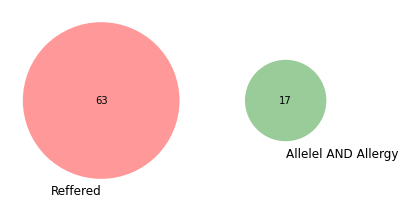

In [294]:
venn2([set(fl),set(allelArticleMap_Allergy.Title.values)],['Reffered', 'Allelel AND Allergy'])

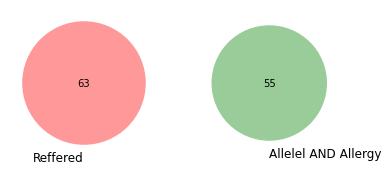

In [295]:
venn2([set(fl),set(allelArticleMap.Title.values)],['Reffered', 'Allelel AND Allergy'])

In [296]:
allelArticleMap_Allergy.loc[set(allelArticleMap_Allergy.index) 
                            - set(allelArticleMap.index)].to_csv("../tables/onlyInallergy.csv")

/var/folders/v9/w_vjbp2j7qb395g17zpzcp180000gp/T/ipykernel_32210/2611590631.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  allelArticleMap_Allergy.loc[set(allelArticleMap_Allergy.index)
